# Housing California Median Price Prediction 

## Introduction

This notebook will contain the code for predicting the `median price` of houses in **California**. The dataset used in this notebook can be found in [This code](/codes/fetch_data.py) which is used to fetch the data from the `urllib` library.

Also, this notebook is related to the `Chapter 2 - End-to-End Machine Learning Project` of the book `Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow` by **Aurélien Géron**.


In [ ]:
!pip install pandas scikit-learn matplotlib seaborn joblib

In [118]:
!pip freeze > requirements.txt

In [119]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame    
from typing import Tuple, Union
from numpy import ndarray 
from zlib import crc32
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix

In [120]:
ROOT: Path = Path.cwd()
DATA: Path = ROOT.parent.parent / 'datasets' / 'housing'

In [121]:
df: DataFrame = pd.read_csv(DATA / 'housing.csv')

In [122]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


As it is possible to see with `df.head()` the dataset contains the following columns:

- `longitude`: A measure of how far west a house is; a higher value is farther west

- `latitude`: A measure of how far north a house is; a higher value is farther north

- `housing_median_age`: Median age of a house within a block; a lower number is a newer building

- `total_rooms`: Total number of rooms within a block

- `total_bedrooms`: Total number of bedrooms within a block

- `population`: Total number of people residing within a block

- `households`: Total number of households, a group of people residing within a home unit, for a block

- `median_income`: Median income for households within a block of houses (measured in tens of thousands of US Dollars)

- `median_house_value`: Median house value for households within a block (measured in US Dollars)

- `ocean_proximity`: Location of the house w.r.t ocean/sea

In [123]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


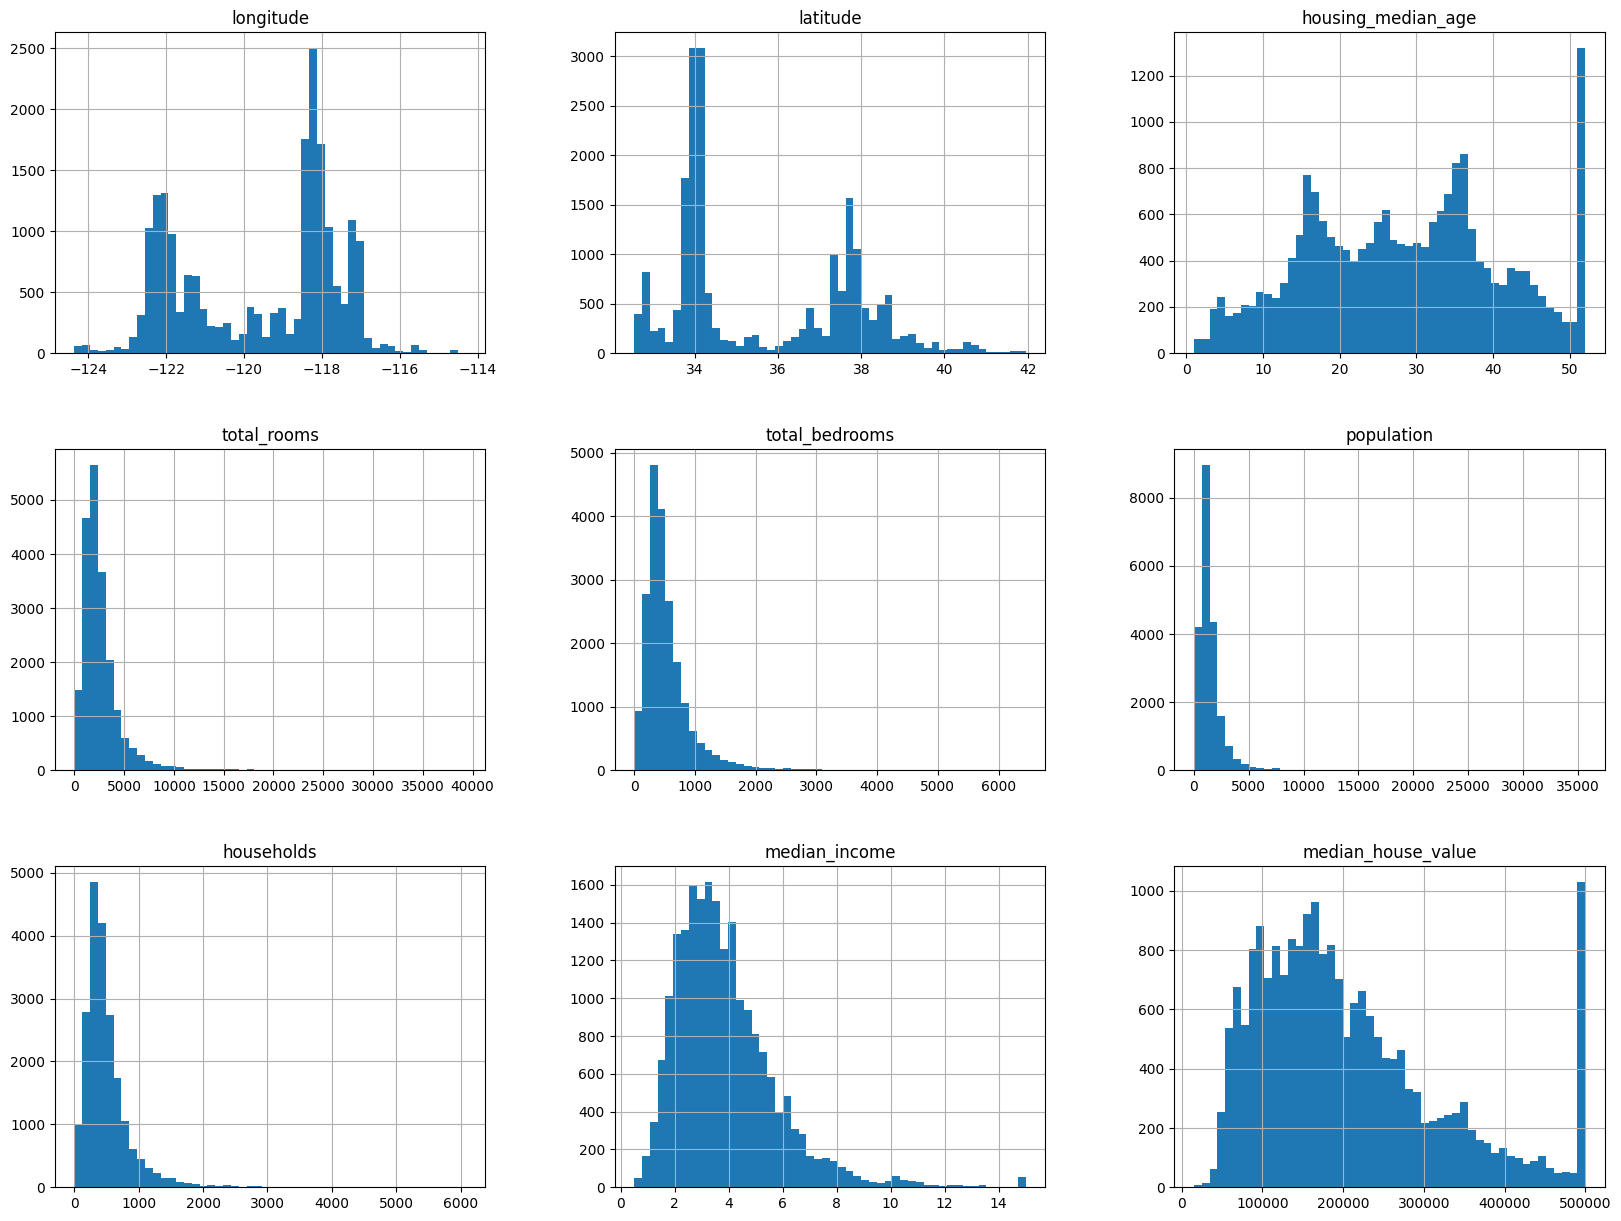

In [124]:
%matplotlib inline
df.hist(bins=50, figsize=(20,15))
plt.show()

Using the `df.hist()` it is possible to show every instance of the dataset in a histogram format.

As it possible to see `median_income` and `median_house_value` are capped, which is a problem because the model may learn that prices never go beyond that limit. This is a problem because the model may not predict the correct price for the houses that are above the limit.

Also, it is possible to notice that many of the hist has tail-heavy, which may make it harder for the model to detect patterns.

In [125]:
def split_train_test(data: pd.DataFrame, test_ratio: float) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the data into training and test sets.

    Parameters
    ----------
    data : pd.DataFrame
        The data to split.
    test_ratio : float
        The ratio of the test set size to the total size.

    Returns
    -------
    Tuple[pd.DataFrame, pd.DataFrame]
        The training set and the test set.
    """

    shuffled_indices: ndarray = np.random.permutation(len(data))
    test_set_size: int = int(len(data) * test_ratio)
    test_indices: ndarray = shuffled_indices[:test_set_size]
    train_indices: ndarray = shuffled_indices[test_set_size:]

    return data.iloc[train_indices], data.iloc[test_indices]

In [126]:
train_set: pd.DataFrame
test_set: pd.DataFrame

train_set, test_set = split_train_test(df, 0.2)

In [127]:
def test_set_check(identifier: Union[int, str], test_ratio: float) -> bool:
    """
    Check if an identifier should go into the test set based on the test ratio.

    Parameters
    ----------
    identifier : Union[int, str]
        The identifier for which the test set check is to be performed. It can be an integer or a string.
    test_ratio : float
        The ratio of the test set to the total set. Should be between 0 and 1.

    Returns
    -------
    bool
        True if the identifier should be in the test set, False otherwise.
    """
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2 ** 32

def split_train_test_by_id(data: pd.DataFrame, test_ratio: float, id_column: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the data into training and test sets based on an identifier.

    Parameters
    ----------
    data : pd.DataFrame
        The data to split.
    test_ratio : float
        The ratio of the test set size to the total size.
    id_column : str
        The column to use as the identifier.

    Returns
    -------
    Tuple[pd.DataFrame, pd.DataFrame]
        The training set and the test set.
    """
    ids: ndarray = data[id_column]
    in_test_set: ndarray = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

df_with_id: pd.DataFrame = df.reset_index()
train_set, test_set = split_train_test_by_id(df_with_id, 0.2, 'index')

## Why calculate a hash to split the data?

To develop a consistent model we must split the data into **training** and **testing** sets. We can easily do this by creating a function to shuffle the data, like the function `split_train_test` that is used in the code. However this method is not consistent, because every time we run the code the data will be shuffled differently, which may lead to different results. 

One possible way to avoid this is using `seed` to shuffle the data. However even this method is not consistent, because if we add more data to the dataset the seed will be different and the data will be shuffled differently.

A good way to handle with this is by seting some identifiers in the data. In this dataset there's no `index`, we can use the `reset_index` method to handle with this. However, if we add more data to the dataset the index will be different and the data will be shuffled differently. In the cell bellow we set a identifier by using a **consistent** column, like the `longitude`.

A `hash` can be used to set a identifier metric to the data. 

```python

    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2 ** 32
```

This code will return a `hash` of the `identifier` and will return `True` if the `hash` is less than the `test_ratio` times `2 ** 32`. This way we can split the data consistently.

In [128]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               16512 non-null  int64  
 1   longitude           16512 non-null  float64
 2   latitude            16512 non-null  float64
 3   housing_median_age  16512 non-null  float64
 4   total_rooms         16512 non-null  float64
 5   total_bedrooms      16348 non-null  float64
 6   population          16512 non-null  float64
 7   households          16512 non-null  float64
 8   median_income       16512 non-null  float64
 9   median_house_value  16512 non-null  float64
 10  ocean_proximity     16512 non-null  object 
dtypes: float64(9), int64(1), object(1)
memory usage: 1.5+ MB


In [129]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4128 entries, 2 to 20629
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               4128 non-null   int64  
 1   longitude           4128 non-null   float64
 2   latitude            4128 non-null   float64
 3   housing_median_age  4128 non-null   float64
 4   total_rooms         4128 non-null   float64
 5   total_bedrooms      4085 non-null   float64
 6   population          4128 non-null   float64
 7   households          4128 non-null   float64
 8   median_income       4128 non-null   float64
 9   median_house_value  4128 non-null   float64
 10  ocean_proximity     4128 non-null   object 
dtypes: float64(9), int64(1), object(1)
memory usage: 387.0+ KB


In [130]:
df['id'] = df['longitude'] * 1000 + df['latitude']

In [131]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-122192.12
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-122182.14
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,-122202.15
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,-122212.15
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-122212.15


In [132]:
train_set, test_set = split_train_test_by_id(df, 0.2, 'id')

In [133]:
"""
train_set_, test_set_ = train_test_split(df, test_size=0.2, random_state=42)
"""

'\ntrain_set_, test_set_ = train_test_split(df, test_size=0.2, random_state=42)\n'

<Axes: >

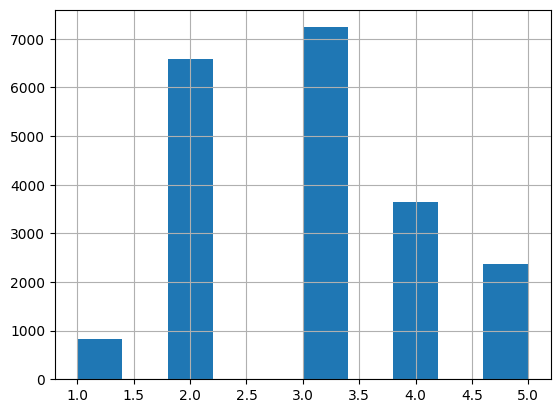

In [134]:
df['income_cat'] = pd.cut(
    df['median_income'],
    bins= [0., 1.5, 3.0, 4.5, 6., np.inf],
    labels= [1, 2, 3, 4, 5]
)

df['income_cat'].hist()

In [135]:
from sklearn.model_selection import StratifiedShuffleSplit

split_ : StratifiedShuffleSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split_.split(df, df['income_cat']):
    strat_train_set: pd.DataFrame = df.loc[train_index]
    strat_test_set: pd.DataFrame = df.loc[test_index]


## Why random split is not a good idea?

Shuffling the data randomly is not always good because it can contain some bias. For example, if we shuffle the data randomly we may have a dataset with a lot of houses in the north and a few houses in the south. If we shuffle the data randomly we may have a training set with only houses in the north and a testing set with only houses in the south. This will lead to a model that is not consistent.

By using `StratifiedShuffleSplit` we can split the data in a way that the data will be consistent.

A **Stratified Sampling** is a sampling method that involves dividing the population into subgroups and then taking a simple random sample from each subgroup. This method is used when the population is diverse and it is important to have a representative sample from each subgroup.

In [136]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

## Displaying the data

A good way to understand the data is by **plotting** it. This way is better for non-technical people to understand the data. Also by plotting the data we can see some patterns that are not visible by just looking at the data. 

By using a `scatter` kind in `latitude` and `longitude` we can see that the data is related to the `California` state.

The `alpha` parameter is used to show the density of the data. By using a `alpha` of `0.1` we can see the density of the data.


<Axes: xlabel='longitude', ylabel='latitude'>

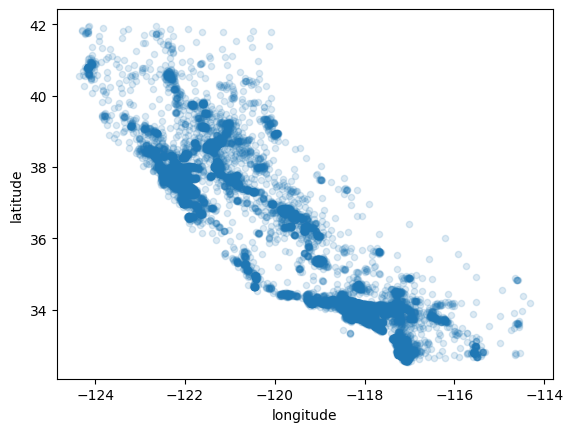

In [137]:
df.plot(
    kind='scatter',
    x='longitude',
    y='latitude',
    alpha=0.15
)

It is possible to improve the plot by using some **parameters**. The usual parameters are:

- `s`: The size of the point
- `c`: The color of the point
- `cmap`: The color map of the point

By setting a `colorbar` we can see the color map of the data.

<Axes: xlabel='longitude', ylabel='latitude'>

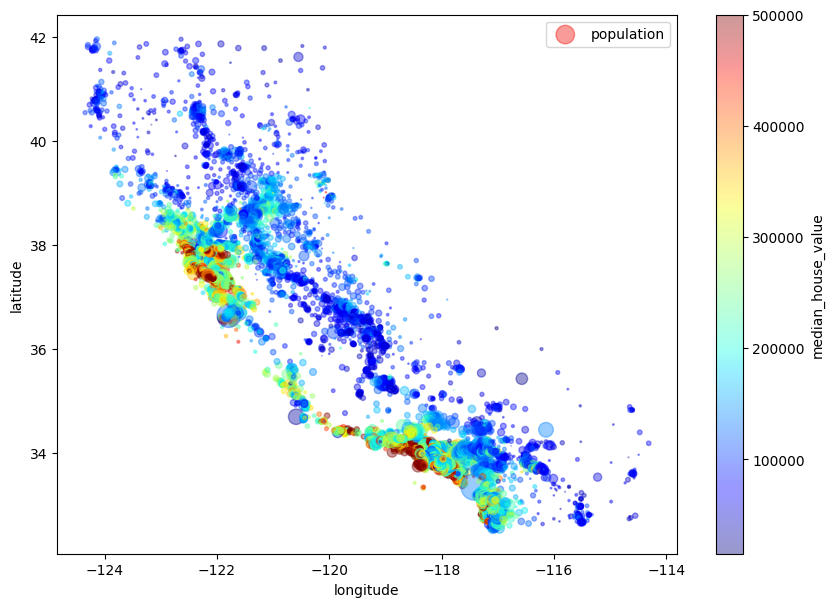

In [138]:
df.plot(
    kind='scatter',
    x='longitude',
    y='latitude',
    alpha=0.4,
    s=df['population']/100,
    label='population',
    figsize=(10,7),
    c='median_house_value',
    cmap=plt.get_cmap('jet'),
    colorbar=True
)

## Correlation

**Correlation** measures the relationship between two variables, specifically how they move together. In machine learning, understanding correlation helps us determine the strength and direction of relationships between features and the target variable.

### Types of Correlation
1. **Positive Correlation**: As one variable increases, the other also increases. A positive correlation is represented by values between 0 and +1.
   - Example: As income increases, the price of a house someone can afford also increases.
   
2. **Negative Correlation**: As one variable increases, the other decreases. A negative correlation is represented by values between 0 and -1.
   - Example: As the age of a house increases, its price might decrease, indicating a negative correlation between the house's age and its price.
   
3. **No Correlation (Zero Correlation)**: When there is no relationship between two variables, the correlation is close to 0.
   - Example: The number of TVs in a household might have no correlation with the price of the house.

### Correlation with the Target Variable
- **Positive Correlation**: When a feature has a positive correlation with the target, it means that as the feature increases, the target also increases. This is not a bad thing; it suggests the feature might help the model make accurate predictions.
- **Negative Correlation**: When a feature has a negative correlation with the target, it means that as the feature increases, the target decreases. Like positive correlation, this is useful information, as it shows a meaningful relationship.
  
#### Key Points
1. **Strong Correlation (Positive or Negative)**: Generally a good sign, as it indicates that the feature has predictive power over the target.
   - Example: If the number of bedrooms has a strong correlation with house price, it can be an important feature in the model.
   
2. **Weak or No Correlation**: A weak or zero correlation suggests that the feature might not be very helpful for predicting the target.
   - However, weak features can still contribute to model accuracy when combined with others.
   
3. **Multicollinearity**: A potential problem occurs when two or more features have a **strong correlation with each other**, known as multicollinearity. This can cause issues in models like linear regression, as it creates redundant information, leading to unstable coefficient estimates.

### Is Correlation (Positive or Negative) with the Target Bad?
- **No, it is not bad**. In fact, correlation (whether positive or negative) is **desirable**, as it suggests a relationship that the model can use to make predictions.
- **What to avoid**: High correlation between features (multicollinearity) rather than between a feature and the target. Multicollinearity can confuse the model by introducing redundant information, leading to poor generalization.

### Summary
- **Positive or negative correlation** with the target is **good**, as long as it makes sense in the problem's context.
- **Multicollinearity between features** should be handled carefully, as it can affect the model's performance, especially in linear models.

Since our dataset is not too large, we can easily compute the standard correlation coefficient (also called Pearson's r) between every pair of attributes using the `corr()` method.

In [139]:
aux: pd.DataFrame = df.drop('ocean_proximity', axis=1)

corr_matrix: pd.DataFrame = aux.corr()

corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
income_cat            0.643892
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
id                   -0.046166
latitude             -0.144160
Name: median_house_value, dtype: float64

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

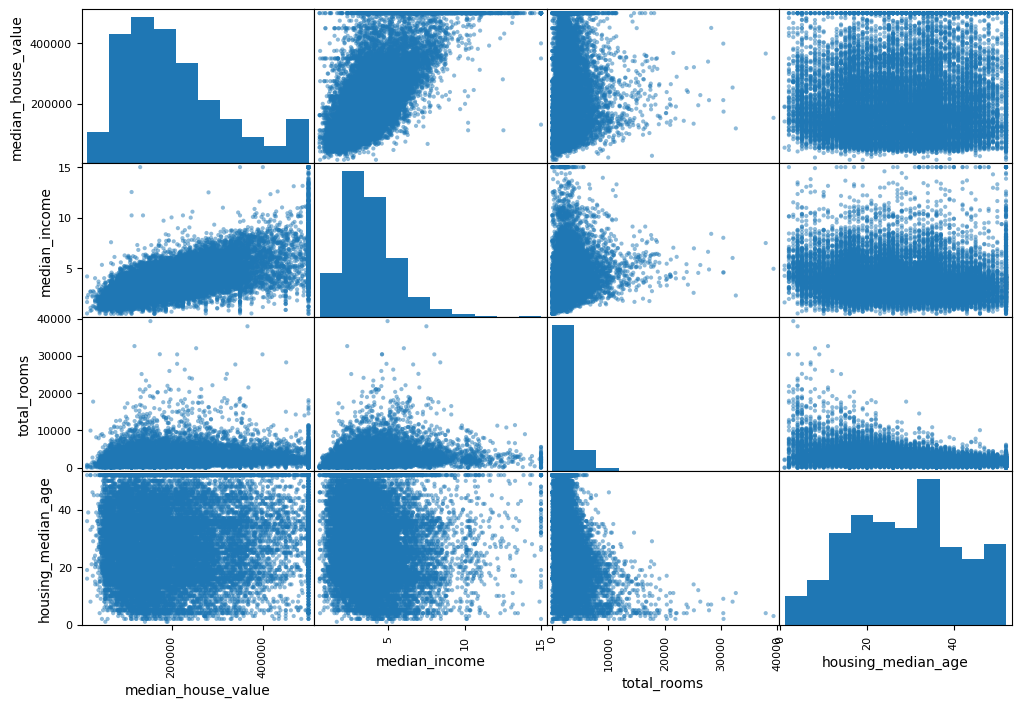

In [140]:
attrs: list = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']

scatter_matrix(df[attrs], figsize=(12, 8))

### Long tail distributions

In statistics, a long tail of some distributions of numbers is the portion of the distribution having a large number of occurrences far from the "head" or central part of the distribution. The distribution could involve popularities, random numbers of occurrences of events with various probabilities. A probability distribution is said to have a long tail, if a larger share of population rests within its tail than would under a normal distribution.

By dealing with long tail distributions we can improve the model by transforming the data. One way to deal with long tail distributions is by using a `log` transformation. This way we can make the data more **normal**.

## Combining Attributes

Sometimes, combining attributes can be more useful than the individual attributes. For example, the total number of rooms in a district is not very useful if you don't know how many households there are. What you really want is the number of rooms per household. Similarly, the total number of bedrooms by itself is not very useful: you probably want to compare it to the number of rooms. And the population per household also seems like an interesting attribute combination to look at.

In [141]:
df['rooms_per_household'] = df['total_rooms'] / df['households']

df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']

df['population_per_household'] = df['population'] / df['households']

In [142]:
aux: pd.DataFrame = df.drop('ocean_proximity', axis=1)

corr_matrix: pd.DataFrame = aux.corr()

corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
income_cat                  0.643892
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
id                         -0.046166
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

## Getting data ready for Machine Learning

In this section we will prepare the data for the machine learning model.

In [143]:
df : pd.DataFrame = strat_train_set.drop(columns=['median_house_value', 'income_cat', 'id'], axis=1)
df_labels: pd.Series = strat_train_set['median_house_value'].copy()

### Data Cleaning

Some ML algorithms cannot work with missing features. When handling missing features, we have three options:

1. Get rid of the corresponding districts.

2. Get rid of the whole attribute.

3. Set the values to some value (zero, the mean, the median, etc.).

We can accomplish these easily using DataFrame's `dropna()`, `drop()`, and `fillna()` methods.

```python

    df.dropna(subset=["total_bedrooms"]) # option 1
    df.drop("total_bedrooms", axis=1) # option 2
    median = df["total_bedrooms"].median() # option 3
    df["total_bedrooms"].fillna(median, inplace=True)
```

**Scikit-Learn** provides a handy class to take care of missing values: `SimpleImputer`. Here is how to use it. First, you need to create a `SimpleImputer` instance, specifying that you want to replace each attribute's missing values with the median of that attribute:

```python

    from sklearn.impute import SimpleImputer

    imputer = SimpleImputer(strategy="median")
```

In [144]:
from sklearn.impute import SimpleImputer

imputer: SimpleImputer = SimpleImputer(strategy='median')

In [145]:
df_num = df.drop('ocean_proximity', axis=1) # since the median can only be computed on numerical attributes

In [146]:
imputer.fit(df_num)

SimpleImputer(strategy='median')

By using `imputer.statistics_` we can see the median of the data.

In [147]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [148]:
df_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [149]:
X : ndarray = imputer.transform(df_num)

df_tr: pd.DataFrame = pd.DataFrame(X, columns=df_num.columns, index=df_num.index)

### Handling Text and Categorical Attributes

Most ML algorithms deals better with numbers and does not accept/can't deal with **text**. When dealing with **text** we can use the `OrdinalEncoder` class to convert the text to numbers.

```python

    from sklearn.preprocessing import OrdinalEncoder

    encoder = OrdinalEncoder()
    housing_cat_encoded = encoder.fit_transform(housing_cat)
```

One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values. This may be fine in some cases (e.g., for ordered categories such as "bad", "average", "good", and "excellent"), but it is obviously not the case for the `ocean_proximity` column (for example, categories 0 and 4 are clearly more similar than categories 0 and 1). To fix this issue, a common solution is to create one binary attribute per category: one attribute equal to 1 when the category is "<category_name>" (and 0 otherwise), another attribute equal to 1 when the category is "<category_name>" (and 0 otherwise), and so on. This is called **one-hot encoding**, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold).

In [150]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [151]:
ordinal_encoder : OrdinalEncoder = OrdinalEncoder()

df_cat_encoded: ndarray = ordinal_encoder.fit_transform(df[['ocean_proximity']])

In [152]:
df_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [153]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

By using `ordinal_encoder.categories_` we can see that the attribute 1 `<1H OCEAN` is near the attribute 4 `NEAR BAY`. This is a problem because the model may learn that the attribute 1 is more similar to the attribute 4 than the attribute 0.

#### One-Hot Encoding

```python

    from sklearn.preprocessing import OneHotEncoder

    cat_encoder = OneHotEncoder()
    housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
```

The `OneHotEncoder` returns a `SciPy` sparse matrix, instead of a `NumPy` array. This is very useful when you have categorical attributes with thousands of categories. After one-hot encoding, we get a matrix with thousands of columns, and the matrix is full of zeros except for a single 1 per row. Using up tons of memory mostly to store zeros would be very wasteful, so instead a sparse matrix only stores the location of the nonzero elements. You can use it mostly like a normal 2D array, but if you really want to convert it to a (dense) `NumPy` array, just call the `toarray()` method.



In [154]:
cat_encoder: OneHotEncoder = OneHotEncoder()

df_cat_1hot: ndarray = cat_encoder.fit_transform(df[['ocean_proximity']])
df_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

In [155]:
print(df_cat_1hot.toarray())

[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


Using a `One-hot Encoder` in a attribute that has many categories may lead to a lot of columns. This may lead to a model that is too slow to train. One way to deal with this is by using a `Embedding` layer in a `Neural Network`.

In [156]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Custom Transformers

A **transformer** is a class that implements three methods: `fit()` (returning `self`), `transform()`, and `fit_transform()`. You can get the last one for free by simply adding `TransformerMixin` as a base class. Also, if you add `BaseEstimator` as a base class (and avoid `*args` and `**kargs` in your constructor), you will get two extra methods (`get_params()` and `set_params()`) that will be useful for automatic hyperparameter tuning.

By creating a custom transformer we can add some attributes to the data. For example, we can add the `rooms_per_household`, `population_per_household` and `bedrooms_per_room` attributes.

In [157]:
from sklearn.base import BaseEstimator, TransformerMixin

In [158]:
rooms_ix : int = 3
bedrooms_ix : int = 4
population_ix : int = 5
households_ix : int = 6

In [159]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room: bool = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [160]:
attr_adder : CombinedAttributesAdder = CombinedAttributesAdder(add_bedrooms_per_room=False)

df_extra_attribs: ndarray = attr_adder.transform(df.values)

### Feature Scaling

One of the most important transformations you need to apply to your data is **feature scaling**. With few exceptions, ML algorithms don't perform well when the input numerical attributes have very different scales. This is the case for the housing data: the total number of rooms ranges from about 6 to 39,320, while the median incomes only range from 0 to 15.

There are two common ways to get all attributes to have the same scale: **min-max scaling** and **standardization**.

**Min-max scaling** Basically, values are shifted and rescaled so that they end up ranging from 0 to 1. We do this by subtracting the min value and dividing by the max minus the min. Scikit-Learn provides a transformer called `MinMaxScaler` for this. It has a `feature_range` hyperparameter that lets you change the range if you don't want 0-1 for some reason. 

$ x_{norm} = \frac{x - x_{min}}{x_{max} - x_{min}} $

**Standardization** First, it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the standard deviation so that the resulting distribution has unit variance. Unlike min-max scaling, standardization does not bound values to a specific range, which may be a problem for some algorithms (e.g., neural networks often expect an input value ranging from 0 to 1). However, standardization is much less affected by outliers. For example, suppose a district had a median income equal to 100 (by mistake). Min-max scaling would then crush all the other values from 0-15 down to 0-0.15, whereas standardization would not be much affected.

$ x_{std} = \frac{x - \mu}{\sigma} $

### Transformation Pipelines

As discussed before, there are many data transformation steps that need to be executed in the right order. A **Pipeline** is a sequence of steps that are executed in order. 

```python

    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler

    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

    housing_num_tr = num_pipeline.fit_transform(housing_num)
```

The `Pipeline` constructor takes a list of name/estimator pairs defining a sequence of steps. All but the last estimator must be transformers (i.e., they must have a `fit_transform()` method). The names can be anything you like (as long as they are unique and don't contain double underscores "__"); they will come in handy later for hyperparameter tuning.

When you call the pipeline's `fit()` method, it calls `fit_transform()` sequentially on all transformers, passing the output of each call as the parameter to the next call until it reaches the final estimator, for which it calls the `fit()` method.

In [161]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline: Pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

df_num_tr: ndarray = num_pipeline.fit_transform(df_num)

`Column Transformer`: This class is used to apply different transformations to different columns. This is useful when you have a dataset with different types of data.

In [162]:
from sklearn.compose import ColumnTransformer

num_attribs: list = list(df_num)
cat_attribs: list = ['ocean_proximity']

In [163]:
full_pipeline: ColumnTransformer = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

df_prepared: ndarray = full_pipeline.fit_transform(df)

## Select and Train a Model

After preparing the data, we can now select and train a model. By dealing with numerical data we can use a simple `Linear Regression` model.

```python

    from sklearn.linear_model import LinearRegression

    lin_reg = LinearRegression()
    lin_reg.fit(housing_prepared, housing_labels)
```

You can find a detailed explanation about **Linear Regression** in this repo: [Linear Regression](https://github.com/pcmoraesmenezes/Calculo/blob/main/Explica%C3%A7%C3%A3o%20de%20Modelos/Regress%C3%A3o%20Linear.md)
 

In [164]:
from sklearn.linear_model import LinearRegression

lin_reg: LinearRegression = LinearRegression()

lin_reg.fit(df_prepared, df_labels)

LinearRegression()

In [165]:
some_data: ndarray = df.iloc[:5]
some_labels: pd.Series = df_labels.iloc[:5]

some_data_prepared: ndarray = full_pipeline.transform(some_data)

print('Predictions:', lin_reg.predict(some_data_prepared), '\nLabels:', list(some_labels))

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089] 
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


### Evaluating the Model

After training a model there's a few possible ways to evaluate it.

#### Mean Squared Error

The **Mean Squared Error (MSE)** is the average of the squares of the errors. The larger the number the larger the error.

$ MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $

#### Root Mean Squared Error

The **Root Mean Squared Error (RMSE)** is the square root of the MSE. The larger the number the larger the error.

$ RMSE = \sqrt{MSE} $


In [166]:
from sklearn.metrics import mean_squared_error

df_predictions: ndarray = lin_reg.predict(df_prepared)

lin_mse: float = mean_squared_error(df_labels, df_predictions)

lin_rmse: float = np.sqrt(lin_mse)

lin_rmse

np.float64(68627.87390018745)

In [167]:
from sklearn.tree import DecisionTreeRegressor

tree_reg: DecisionTreeRegressor = DecisionTreeRegressor()

tree_reg.fit(df_prepared, df_labels)

DecisionTreeRegressor()

In [168]:
df_predictions: ndarray = tree_reg.predict(df_prepared)

tree_mse: float = mean_squared_error(df_labels, df_predictions)

tree_rmse: float = np.sqrt(tree_mse)

tree_rmse

np.float64(0.0)

### Cross-Validation

One way to evaluate the model is by using the `cross_val_score` method. This method will split the data into `k` folds and will train the model `k` times. This way we can have a better evaluation of the model.

```python

    from sklearn.model_selection import cross_val_score

    scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
    lin_rmse_scores = np.sqrt(-scores)
```

A **negative** sign is used because `cross_val_score` expects a utility function (greater is better) rather than a cost function (lower is better), so the scoring function is actually the opposite of the MSE (i.e., a negative value), which is why the preceding code computes `-scores` before calculating the square root.

In [169]:
from sklearn.model_selection import cross_val_score

scores: ndarray = cross_val_score(tree_reg, df_prepared, df_labels, scoring='neg_mean_squared_error', cv=10)

tree_rmse_scores: ndarray = np.sqrt(-scores)

In [170]:
def display_scores(scores: ndarray) -> None:
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())

display_scores(tree_rmse_scores)

Scores: [70825.70541475 71574.37360159 69224.26087758 72050.90375871
 68773.35055541 77977.84984803 71564.26458364 72404.07159019
 68639.05006703 70877.98303691]
Mean: 71391.18133338509
Standard deviation: 2541.9450023239297


In [171]:
lin_scores: ndarray = cross_val_score(lin_reg, df_prepared, df_labels, scoring='neg_mean_squared_error', cv=10)

In [172]:
lin_rmse_scores: ndarray = np.sqrt(-lin_scores)

display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.328209818062


In [173]:
from sklearn.ensemble import RandomForestRegressor

forest_reg: RandomForestRegressor = RandomForestRegressor()

forest_reg.fit(df_prepared, df_labels)

df_predictions: ndarray = forest_reg.predict(df_prepared)

forest_mse: float = mean_squared_error(df_labels, df_predictions)

forest_rmse: float = np.sqrt(forest_mse)

forest_rmse

np.float64(18737.309891692417)

## How to improve the model

There are a few ways to improve the model:

1. **Feature Engineering**: By adding more features to the model we can improve the model. For example, we can add the `bedrooms_per_room` feature.

2. **Hyperparameter Tuning**: By tuning the hyperparameters of the model we can improve the model. For example, we can tune the `n_estimators` of the `RandomForestRegressor`.

3. **Ensemble Methods**: By using ensemble methods we can improve the model. For example, we can use a `RandomForestRegressor` instead of a `LinearRegression`.

4. **Grid Search**: By using `GridSearchCV` we can find the best hyperparameters for the model.

5. **Randomized Search**: By using `RandomizedSearchCV` we can find the best hyperparameters for the model.

6. **Analyze the Best Models and Their Errors**: By analyzing the best models we can find patterns that are not visible by just looking at the data.

### Grid Search

`Grid Search` is a method used to find the best hyperparameters for the model. This method will test every possible combination of hyperparameters and will return the best one.

```python

    from sklearn.model_selection import GridSearchCV

    param_grid = [
        {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
        {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
    ]

    forest_reg = RandomForestRegressor()

    grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

    grid_search.fit(housing_prepared, housing_labels)
```

### Randomized Search

`Randomized Search` is a method used to find the best hyperparameters for the model. This method will test a random combination of hyperparameters and will return the best one.

```python

    from sklearn.model_selection import RandomizedSearchCV

    param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

    forest_reg = RandomForestRegressor()

    rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

    rnd_search.fit(housing_prepared, housing_labels)
```

In [174]:
from sklearn.model_selection import GridSearchCV

param_grid: dict = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg: RandomForestRegressor = RandomForestRegressor()

grid_search: GridSearchCV = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(df_prepared, df_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [175]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [176]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

In [177]:
cvres: dict = grid_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

63354.23146072685 {'max_features': 2, 'n_estimators': 3}
55748.00926120831 {'max_features': 2, 'n_estimators': 10}
52541.60625380231 {'max_features': 2, 'n_estimators': 30}
59966.08689729984 {'max_features': 4, 'n_estimators': 3}
52697.44687692648 {'max_features': 4, 'n_estimators': 10}
50429.941313859876 {'max_features': 4, 'n_estimators': 30}
58346.88677662985 {'max_features': 6, 'n_estimators': 3}
52563.52145286781 {'max_features': 6, 'n_estimators': 10}
50210.199407362794 {'max_features': 6, 'n_estimators': 30}
58324.574980547986 {'max_features': 8, 'n_estimators': 3}
52253.579436366985 {'max_features': 8, 'n_estimators': 10}
50171.68789379062 {'max_features': 8, 'n_estimators': 30}
62631.978580589064 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53898.788045756824 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60091.85716784581 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52425.508986399735 {'bootstrap': False, 'max_features': 3, 'n_estimato

In [179]:
import joblib

joblib.dump(grid_search, 'grid_search.pkl')

grid_search_loaded: GridSearchCV = joblib.load('grid_search.pkl')


In [178]:
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import randint

param_distribs: dict = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=8)
}

forest_reg: RandomForestRegressor = RandomForestRegressor()

rnd_search: RandomizedSearchCV = RandomizedSearchCV(forest_reg, param_distributions=param_distribs, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

rnd_search.fit(df_prepared, df_labels)

cvres: dict = rnd_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

49060.48536985235 {'max_features': 7, 'n_estimators': 180}
50788.301908484966 {'max_features': 5, 'n_estimators': 15}
50498.7942306001 {'max_features': 3, 'n_estimators': 72}
50597.30072996967 {'max_features': 5, 'n_estimators': 21}
49270.00933694404 {'max_features': 7, 'n_estimators': 122}
50464.07502028975 {'max_features': 3, 'n_estimators': 75}
50302.86139351718 {'max_features': 3, 'n_estimators': 88}
49431.44127488268 {'max_features': 5, 'n_estimators': 100}
50218.52927575974 {'max_features': 3, 'n_estimators': 150}
64089.203319666034 {'max_features': 5, 'n_estimators': 2}


## Ensemble Methods

`Ensemble Methods` are methods used to combine multiple models to improve the model. One example of ensemble methods is the `RandomForestRegressor`.

```python

    from sklearn.ensemble import RandomForestRegressor

    forest_reg = RandomForestRegressor()
    forest_reg.fit(housing_prepared, housing_labels)
```

In [180]:
rnd_search.best_params_

{'max_features': 7, 'n_estimators': 180}

In [181]:
feature_importances : ndarray = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.68771015e-02, 5.95310841e-02, 4.28394975e-02, 1.64449991e-02,
       1.49353259e-02, 1.56108984e-02, 1.40657987e-02, 3.66849845e-01,
       5.46961196e-02, 1.10710728e-01, 5.33496136e-02, 6.34367431e-03,
       1.72228074e-01, 1.04972640e-04, 2.15421642e-03, 3.25805161e-03])

In [182]:
extra_attribs: list = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']

cat_encoder: OneHotEncoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs: list = list(cat_encoder.categories_[0])

attributes: list = num_attribs + extra_attribs + cat_one_hot_attribs

sorted(zip(feature_importances, attributes), reverse=True)

[(np.float64(0.3668498449875724), 'median_income'),
 (np.float64(0.17222807363361545), 'INLAND'),
 (np.float64(0.11071072819289868), 'pop_per_hhold'),
 (np.float64(0.06687710148449579), 'longitude'),
 (np.float64(0.0595310840617943), 'latitude'),
 (np.float64(0.054696119594029216), 'rooms_per_hhold'),
 (np.float64(0.05334961355844374), 'bedrooms_per_room'),
 (np.float64(0.04283949745019631), 'housing_median_age'),
 (np.float64(0.016444999122274713), 'total_rooms'),
 (np.float64(0.015610898372254474), 'population'),
 (np.float64(0.014935325879394333), 'total_bedrooms'),
 (np.float64(0.014065798686885957), 'households'),
 (np.float64(0.006343674309271848), '<1H OCEAN'),
 (np.float64(0.0032580516073847337), 'NEAR OCEAN'),
 (np.float64(0.0021542164195393664), 'NEAR BAY'),
 (np.float64(0.00010497263994860654), 'ISLAND')]

In [183]:
final_model : RandomForestRegressor = grid_search.best_estimator_

X_test: pd.DataFrame = strat_test_set.drop('median_house_value', axis=1)
y_test: pd.Series = strat_test_set['median_house_value'].copy()

X_test_prepared: ndarray = full_pipeline.transform(X_test)

final_predictions: ndarray = final_model.predict(X_test_prepared)

final_mse: float = mean_squared_error(y_test, final_predictions)

final_rmse: float = np.sqrt(final_mse)

In [184]:
from scipy import stats

confidence: float = 0.95

squared_errors: ndarray = (final_predictions - y_test) ** 2

np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([46464.96576156, 50490.36110318])

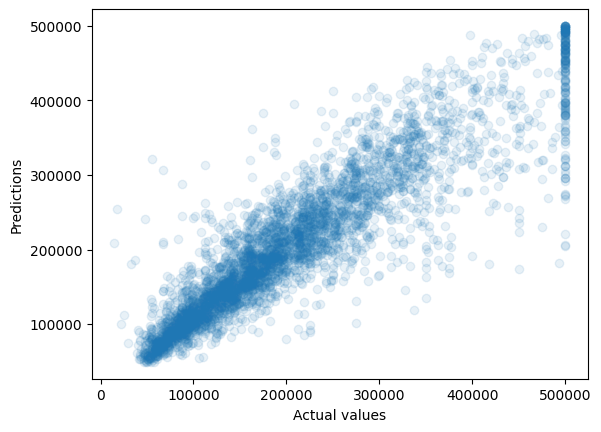

In [188]:
import matplotlib.pyplot as plt
plt.scatter(y_test, final_predictions, alpha=0.1)
plt.xlabel('Actual values')
plt.ylabel('Predictions')
plt.show()